# GAN
In this notebook, we are going to be focusing on the generative adversarial network trainer in the gan module of PAI-Utils.

## Setup
We will first need to import packages and get the Shapes3D dataset.

### Import Packages

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow import keras
import matplotlib.pyplot as plt
from IPython.display import Image, display

from paiutils import image
from paiutils import neural_network as nn
from paiutils import gan

# see if using GPU and if so enable memory growth
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Get Shapes3D Dataset
1. Download the dataset
2. Partition data into train and validation data
3. Preprocess train and validation data
4. Batch the datasets and create a dictionary of the data

In [2]:
# Get dataset
shapes3d = tfds.image.Shapes3d()
shapes3d.download_and_prepare()
print(shapes3d.info.features)
print(shapes3d.info.splits)
data = shapes3d.as_dataset()['train']

# Split data
data_len = len(data)
data = data.shuffle(data_len)
val_len = int(data_len * .1)
val_data = data.take(val_len)
train_data = data.skip(val_len)

# Preprocess train dataset
def train_preprocess(x):
    # resizing for computational efficiency
    x = tf.image.resize(
        x['image'], (32, 32),
        method=tf.image.ResizeMethod.AREA
    )
    x = (tf.cast(x, tf.float32) - 127.5) / 127.5
    return x, x
train_data = train_data.map(train_preprocess)
print(len(train_data))

# Preprocess validation dataset
# Note, we use a different
# preprocess method for validation data
# because a different format is needed
# than for training.
def val_preprocess(x):
    # resizing for computational efficiency
    x = tf.image.resize(
        x['image'], (32, 32),
        method=tf.image.ResizeMethod.AREA
    )
    x = (tf.cast(x, tf.float32) - 127.5) / 127.5
    return x, tf.ones(1)
val_data = val_data.map(val_preprocess)

batch_size = 32
data = {'train': train_data.repeat().batch(batch_size),
        'validation': val_data.batch(batch_size)}
shape = train_data.element_spec[0].shape

FeaturesDict({
    'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
    'label_floor_hue': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    'label_object_hue': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    'label_orientation': ClassLabel(shape=(), dtype=tf.int64, num_classes=15),
    'label_scale': ClassLabel(shape=(), dtype=tf.int64, num_classes=8),
    'label_shape': ClassLabel(shape=(), dtype=tf.int64, num_classes=4),
    'label_wall_hue': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    'value_floor_hue': tf.float32,
    'value_object_hue': tf.float32,
    'value_orientation': tf.float32,
    'value_scale': tf.float32,
    'value_shape': tf.float32,
    'value_wall_hue': tf.float32,
})
{'train': <tfds.core.SplitInfo num_examples=480000>}
432000


## Create the Model
We will now need to make a generative network that will create images and a discriminator network that will be able to determine if an image is real or fake.

In [3]:
noise_size = 100
x0 = keras.layers.Input(shape=(noise_size,))
x = nn.dense(4*4*512)(x0)
x = keras.layers.Reshape((4, 4, 512))(x)
x = nn.conv2d(256, 3, 2, transpose=True)(x)
x = nn.conv2d(128, 3, 2, transpose=True)(x)
x = nn.conv2d(64, 3, 2, transpose=True)(x)
output = nn.conv2d(3, 1, 1, activation='tanh',
                   batch_norm=False)(x)
gen_model = keras.Model(inputs=x0, outputs=output)
gen_model.compile(optimizer=keras.optimizers.Adam(.0002, beta_1=.5),
                  loss='mse')
gen_model.summary()

x0 = keras.layers.Input(shape=(32, 32, 3))
x = nn.conv2d(64, 3, 2, activation=None,
              batch_norm=False)(x0)
x = keras.layers.LeakyReLU(alpha=0.2)(x)
x = keras.layers.Dropout(.4)(x)
x = nn.conv2d(128, 3, 2, activation=None)(x)
x = keras.layers.LeakyReLU(alpha=0.2)(x)
x = keras.layers.Dropout(.4)(x)
x = nn.conv2d(256, 3, 2, activation=None)(x)
x = keras.layers.LeakyReLU(alpha=0.2)(x)
x = keras.layers.Dropout(.4)(x)
x = nn.conv2d(512, 3, 2, activation=None)(x)
x = keras.layers.LeakyReLU(alpha=0.2)(x)
x = keras.layers.Dropout(.4)(x)
x = keras.layers.Flatten()(x)
# The GAN Trainer will apply a sigmoid to this output
output = nn.dense(1, activation=None, batch_norm=False)(x)
dis_model = keras.Model(inputs=x0, outputs=output)
dis_model.compile(optimizer=keras.optimizers.Adam(.0002, beta_1=.5),
                  loss='binary_crossentropy')
dis_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 8192)              819200    
_________________________________________________________________
batch_normalization (BatchNo (None, 8192)              32768     
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         1179648   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)      

## Train the Model
We can now use the GANTrainer to train the generative and discriminative models on the dataset.

In [4]:
steps_per_epoch = int(len(train_data) // batch_size)
trainer = gan.GANTrainer(
    gen_model, dis_model, data,
    idt_loss_coef=10
)
trainer.train(10, steps_per_epoch=steps_per_epoch)
path = trainer.save('')

Epoch 1/10
13500/13500 [==============================] - 178s 13ms/step - gen_loss: 14.4210 - adversarial_loss: 5.2848 - identity_loss: 0.9136 - discriminator_loss: 0.2008 - dis_fake_input_loss: 0.0953 - dis_real_input_loss: 0.1055 - val_loss: 0.3604
Epoch 2/10
13500/13500 [==============================] - 177s 13ms/step - gen_loss: 14.5914 - adversarial_loss: 5.2088 - identity_loss: 0.9383 - discriminator_loss: 0.2182 - dis_fake_input_loss: 0.1038 - dis_real_input_loss: 0.1145 - val_loss: 0.3027
Epoch 3/10
13500/13500 [==============================] - 177s 13ms/step - gen_loss: 14.8631 - adversarial_loss: 5.4707 - identity_loss: 0.9392 - discriminator_loss: 0.2125 - dis_fake_input_loss: 0.1006 - dis_real_input_loss: 0.1119 - val_loss: 0.4571
Epoch 4/10
13500/13500 [==============================] - 179s 13ms/step - gen_loss: 15.0900 - adversarial_loss: 5.6778 - identity_loss: 0.9412 - discriminator_loss: 0.2017 - dis_fake_input_loss: 0.0945 - dis_real_input_loss: 0.1072 - val_loss:

## Evaluate the Discriminator
Before testing the generator, we can evaluate the discriminator by getting losses for the validation data.

In [5]:
print(trainer.eval(batch_size=100, train_data=False))

Validation Data Evaluation: 
100/100 [==============================] - 1s 6ms/step - loss: 0.9592
{'Validation': 0.9591594934463501}


## Test the Generator
The model is now trained and saved, so we can test the generative model by using the GANPredictor to create a grid of generated images.

#### Load Generator

In [6]:
# path = 'trained_model1'
generator = gan.GANPredictor(path)

#### Display Grid of Generated Images

We will now create and display a grid of generated images.

-0.9999274 0.99832016


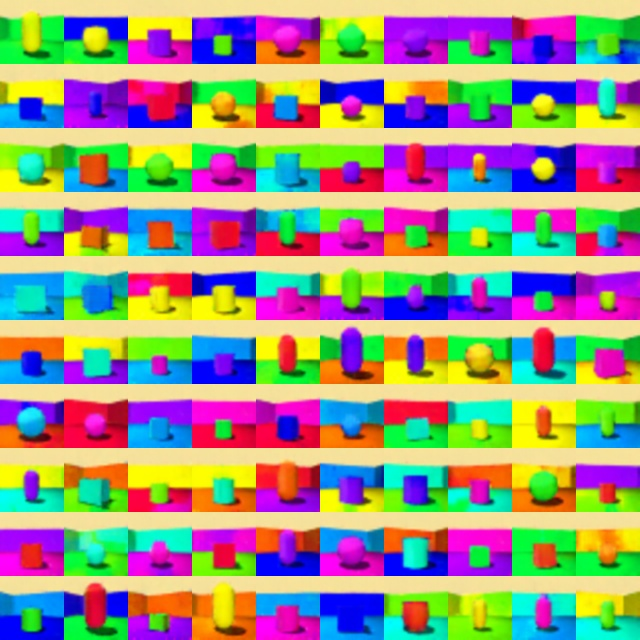

In [7]:
scale = int(2)
num_cols = 10
num_rows = 10

for _ in range(1):
    imgs = generator.generate(n=num_cols * num_rows)
    imgs = [image.pyr(image.denormalize(img), scale - 1)
            for img in imgs]
    grid = np.array(imgs).reshape((num_rows, num_cols, *imgs[0].shape), order='F')
    grid = np.hstack(np.hstack(grid))
    ret = image.cv2.imencode('.jpg', grid)[1]
    display(Image(data=ret))

The generator was able to generate some unique images, though they are not necessarily of convincing quality.